<center>
    <tr>
    <td><img src="images/Quansight_Logo_Lockup_1.png" width="25%"></img></td>
    </tr>
</center>

---
# PyTorch Convolutional NN for MNIST Classification
---

## Lesson plan

- Convolutional layers vs. fully-connected layers
- Use tensorboard to inspect network training
- Use GPU to speed-up network training (*this notebook is very slow without access to a GPU*)
- Compute class-wise accuracy

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pathlib

/home/conda/filesystem/438d9d1908d971c2b2a0f4b2cc683166d536833753f26b4a46bd996c613e5b77-20220604-044417-292940-71-cybera/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MNIST_PATH = pathlib.Path('.') / 'data'

In [3]:
transform = transforms.Compose([transforms.ToTensor()]) 

In [4]:
trainset = torchvision.datasets.MNIST(root=MNIST_PATH, train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root=MNIST_PATH, train=False, download=True, transform=transform)

print(f'Number of images in training set: {len(trainset)}')
print(f'Number of images in test set is: {len(testset)}')

9913344it [00:00, 77507467.29it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



29696it [00:00, 43996485.90it/s]         

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1649664it [00:00, 30488276.13it/s]         


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



5120it [00:00, 21199246.28it/s]         

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Number of images in training set: 60000
Number of images in test set is: 10000



/home/conda/filesystem/438d9d1908d971c2b2a0f4b2cc683166d536833753f26b4a46bd996c613e5b77-20220604-044417-292940-71-cybera/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650943831247/work/torch/csrc/utils/tensor_numpy.cpp:172.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Setting up a convolutional neural network

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Net(nn.Module):
    
    def __init__(self, use_conv):
        super(Net, self).__init__()
        
        self.use_conv = use_conv
        
        if self.use_conv:
            self.conv1 = nn.Conv2d(1, 8, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(8, 16, 5)
        else:
            self.fc0 = nn.Linear(28*28, 16*4*4)
        
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x, dbg=False):
        if dbg: print('input: ', x.shape)
        
        if self.use_conv:
            if dbg: print('start of conv. block')
            x = self.pool(F.relu(self.conv1(x)))
            if dbg: print(x.shape)
            x = self.pool(F.relu(self.conv2(x)))
            if dbg: 
                print(x.shape)
                print('end of conv. block')
        else:
            if dbg: print('No conv block')
            x = x.view(-1, 28*28)
            x = F.relu(self.fc0(x))
        
        if dbg: print('start of linear block')
        x = x.view(-1, 16*4*4)
        if dbg: print(x.shape)
        x = F.relu(self.fc1(x))
        if dbg: print(x.shape)
        x = F.relu(self.fc2(x))
        if dbg: 
            print(x.shape)
            print('end of linear block')
        return x

### Lets check the model

In [9]:
use_conv = False # keep this as-is for the moment, just for funsies

In [10]:
net = Net(use_conv=use_conv)
im, l = trainset[0]
net(im.unsqueeze(0), dbg=False)
#list(net.parameters())

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')

Total parameters: 233010


## Training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla K80


In [12]:
net = Net(use_conv=use_conv).to(device)

### Loss

In [13]:
criterion = nn.CrossEntropyLoss().to(device)

### Optimizer

In [14]:
import torch.optim as optim

In [15]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard for visualizing training performance

In [16]:
try:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummerWriter()
except:
    writer = None

In [17]:
datasets = {
    'train': trainset,
    'val': testset
}

dataloaders = {
    'train': trainloader,
    'val': testloader
}

In [18]:
starting_epoch = 0
num_epochs = 30

In [19]:
running_losses = {'train': [], 'val': []}
running_accs = {'train': [], 'val': []}

for epoch in range(starting_epoch, starting_epoch+num_epochs):
    
    running_loss = {'train': 0.0, 'val': 0.0}
    running_acc = {'train': 0.0, 'val': 0.0}
    
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train(True)
        else:
            net.train(False)
        
        running_loss = 0.0
        running_acc = 0.0
       
        for batch_i, samples in enumerate(dataloaders[phase]):
            images, labels = samples
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            
            error = criterion(outputs, labels)
            running_loss += error.item()
        
            _, predicted = torch.max(outputs, 1)
            running_acc += (predicted == labels).sum().item()
        
            # check out model.eval()
        
            if phase == 'train':
                optimizer.zero_grad()
                error.backward()
                optimizer.step()
        
        running_losses[phase].append( running_loss / len(datasets[phase]) )
        running_accs[phase].append( running_acc * 100.0 / len(datasets[phase]) )
    
    if writer:
        writer.add_scalar('Loss/train', running_losses['train'][-1], epoch)
        writer.add_scalar('Loss/validation', running_losses['val'][-1], epoch)
        writer.add_scalar('Accuracy/train', running_accs['train'][-1], epoch)
        writer.add_scalar('Accuracy/validation', running_accs['val'][-1], epoch)
    
    
    if epoch % 10 == 0:
        print('epoch={}, training err={:6.4}/acc={}, validation err={:6.4}/acc={}'.format(epoch, 
                                                                            running_losses['train'][-1], 
                                                                            running_accs['train'][-1],
                                                                            running_losses['val'][-1],
                                                                            running_accs['val'][-1]))
        
starting_epoch = epoch
print('Training done')

epoch=0, training err=0.03185/acc=41.16833333333334, validation err=0.02439/acc=54.23
epoch=10, training err=0.01385/acc=65.71166666666667, validation err=0.0137/acc=66.15
epoch=20, training err=0.01279/acc=67.3, validation err=0.0128/acc=67.54
Training done


## Computing class-specific accuracy

In [20]:
%%time
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for k in range(len(data)):
            label = labels[k]
            class_correct[label] += c[k].item()
            class_total[label] += 1

CPU times: user 299 ms, sys: 154 ms, total: 453 ms
Wall time: 892 ms


In [21]:
for i in range(10):
    print('Accuracy of {:5s} : {:4.1f}%'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0     : 100.0%
Accuracy of 1     :  0.0%
Accuracy of 2     : 87.9%
Accuracy of 3     : 96.9%
Accuracy of 4     : 97.3%
Accuracy of 5     :  0.0%
Accuracy of 6     :  0.0%
Accuracy of 7     : 97.1%
Accuracy of 8     : 100.0%
Accuracy of 9     : 92.1%


From [matplotlib's documentation on creating heatmaps](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html), we can visualize the confusion matrix:

In [22]:
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:2d}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
%%time
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for k in range(len(data)):
            label = labels[k]
            class_correct[label] += c[k].item()
            class_total[label] += 1

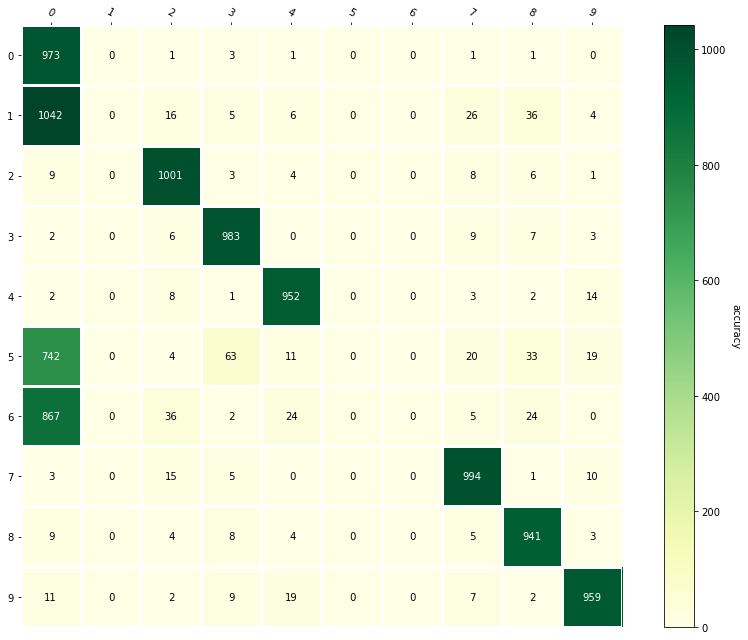

In [32]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

# iterate over test data
n = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        output = net(images) # Feed Network

        pred = torch.max(output, 1)[1].cpu().numpy()
        y_pred.extend(pred) # Save Prediction
        
        labels = labels.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize = (12, 9))

im, cbar = heatmap(cf_matrix, np.arange(10), np.arange(10), ax=ax,
                   cmap="YlGn", cbarlabel="accuracy")
texts = annotate_heatmap(im)

fig.tight_layout()

plt.show()

## Summary

+ Using convolutions in PyTorch for image data
+ The advantages and disadvantages of "parameter sharing" in neural networks
+ Multi-class classification in PyTorch
+ Using confusion matrices to visualize classifier performance

<center>
    <tr>
    <td><img src="images/Quansight_Logo_Lockup_1.png" width="25%"></img></td>
    </tr>
</center>